# **MLP**

For MLP, we implemented 1-hidden layer MLP and 2-hidden layer MLP. We tried gradient descent, SGD, and SGD with momentum. For the activation function, we tried sigmoid, RELU, and leaky RELU.

## 1-hidden layer MLP

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from keras.datasets import cifar10
import time

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    

file_prefix = "./data/cifar-10-batches-py/"
x = []
y = []

for i in range(1,6):
    file_name = file_prefix + "data_batch_" + str(i)
    f = unpickle(file_name)
    x.append(f[b'data'])       # a 10000x3072 numpy array of uint8
    y.append(np.array(f[b'labels']))    # a list of 10000 numbers in the range 0-9
    xtemp = f[b'data']
    ytemp = np.array(f[b'labels']).reshape(10000,-1)

x = np.array(x).reshape(50000, -1)

x_train = x
y = np.array(y).reshape(50000, -1)


one_hot_labels = np.zeros((50000, 10))

for i in range(50000):
    one_hot_labels[i, y[i]] = 1


# load test data 
x_test = []
y_test = []

file_name = file_prefix + "test_batch"
f = unpickle(file_name)
x_test.append(f[b'data'])       # a 10000x3072 numpy array of uint8
y_test.append(np.array(f[b'labels']))    # a list of 10000 numbers in the range 0-9

x_test = np.array(x_test).reshape(10000, -1)
y_test = np.array(y_test).reshape(10000, -1)


def sigmoid(s):
    return 1/(1 + np.exp(-s))


def sigmoid_derv(s):
    return s * (1 - s)


def relu(X): 
    return np.maximum(X, 0)


def relu_der(X):
    indices = X > 0
    result = np.zeros(X.shape)
    result[indices] = 1
    return result

def leakyrelu(x1, alpha=0.01):
	  return np.maximum(x1, x1 * 0.01)
   
def leakyrelu_der(X, alpha=0.01):
    indices = X < 0
    result = np.ones(X.shape)
    result[indices] = 0.01
    return result

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)


def cross_entropy(p, r):
    n = r.shape[0]
    ce_sum = p - r
    ce = ce_sum/n
    return ce
    

def error(p, r):
    n = r.shape[0]
    erri = - np.log(p[np.arange(n), r.argmax(axis=1)])
    err = np.sum(erri)/n
    return err


class MLP:
    def __init__(self, x, y):
        # sgd
        batch = np.random.randint(0, x.shape[0], (4))
        self.x = x[batch, :]
        self.y = y[batch, :]
        print(self.x.shape, " ,", self.y.shape)
        h = 128
        self.lr = 0.0001
        x1 = x.shape[1]
        y1 = y.shape[1]
        self.n = x.shape[0]

        self.w1 = np.random.randn(x1, h)*.01
        self.b1 = np.ones((1, h))
        self.w2 = np.random.randn(h, y1)*.01
        self.b2 = np.ones((1, y1))

        self.z1 = np.zeros((self.n, h))
        self.z2 = np.zeros((self.n, y1))
        self.dw2 = np.zeros((h, y1))
        self.dw1 = np.zeros((x1, h))
 

    def forward(self):
        self.z1 = np.dot(self.x, self.w1) + self.b1  # n, 128
        self.a1 = relu(self.z1)                 
        self.z2 = np.dot(self.a1, self.w2) + self.b2 # n, 10
        self.a2 = softmax(self.z2)
        
    def back(self):
        # #-----------------sgd-----------------
        # da2 = cross_entropy(self.a2, self.y)
        # dz2 = da2 # n, 10
        # self.dw2 = 0.99 * np.dot(self.a1.T, dz2) + 0.01 * self.dw2 # 128, 10
        # da1 = np.dot(dz2, self.w2.T)    # n, 128
        # dz1 = da1 * relu_der(self.z1)     # n, 128
        # self.dw1 = 0.9 * np.dot(self.x.T, dz1) + 0.1 * self.dw1  # 10, 128
        # self.w2 -= self.lr * self.dw2
        # self.w1 -= self.lr * self.dw1
        #-----------------momentum-----------------
        da2 = cross_entropy(self.a2, self.y)
        dz2 = da2 # n, 10
        self.dw2 = 0.9 * np.dot(self.a1.T, dz2) + 0.1 * self.dw2 # 128, 10
        da1 = np.dot(dz2, self.w2.T)    # n, 128
        dz1 = da1 * relu_der(self.z1)     # n, 128
        self.dw1 = 0.9 * np.dot(self.x.T, dz1) + 0.1 * self.dw1  # 10, 128
        self.w2 -= self.lr * self.dw2
        self.w1 -= self.lr * self.dw1

    def predict(self, data):
        self.x = data
        self.forward()
        return self.a2
			
model = MLP(x_train, one_hot_labels)
epochs = 10000
result = []
t1= time.time()
for i in range(epochs):
    # sgd
    batch = np.random.randint(0, x_train.shape[0], (100))
    model.x = x_train[batch, :]
    model.y = one_hot_labels[batch, :]
    model.forward()
    model.back()
    if i%500 == 0:
      r = error(model.predict(model.x), model.y)
      np.append(result,[r])
      print("error:", r)
# print(r)
# rshape = r.shape
# plt.plot(rshape,r)
# plt.xlabel('1000 epochs')
# plt.ylabel('cross entropy')
acc = 0
for a,b in zip(x_train, y):
  s = model.predict(a)
  if b == (np.argmax(s)):
    acc +=1
accuracy= acc/len(x_train)*100
print("Training accuracy : ", accuracy)
print("--- %s seconds ---" % (time.time() - t1))
acc = 0
for a,b in zip(x_test, y_test):
  s = model.predict(a)
  if b == (np.argmax(s)):
    acc +=1
accuracy= acc/len(x_test)*100
print("Test accuracy : ", accuracy)

Files already downloaded and verified
Files already downloaded and verified
(4, 3072)  , (4, 10)
error: 9.818321920446074
error: 1.8166134035889288
error: 1.6264867275715362
error: 1.4582638996375976
error: 1.7389891013493222
error: 1.6965588714770672
error: 1.472014028525277
error: 1.8449620727715907
error: 1.4833901356284362
error: 1.6086799432157395
error: 1.4291353303877548
error: 1.5600784745067475
error: 1.5707721267916626
error: 1.5526311594291562
error: 1.3598931228722035
error: 1.5512372251399404
error: 1.3813275712226052
error: 1.4672183327547428
error: 1.3161742260856086
error: 1.4997509810858107
Training accuracy :  47.75
--- 126.64086627960205 seconds ---
Test accuracy :  45.08


## 2-hidden layer MLP

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from keras.datasets import cifar10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    

file_prefix = "./data/cifar-10-batches-py/"
x = []
y = []

for i in range(1,6):
    file_name = file_prefix + "data_batch_" + str(i)
    f = unpickle(file_name)
    x.append(f[b'data'])       # a 10000x3072 numpy array of uint8
    y.append(np.array(f[b'labels']))    # a list of 10000 numbers in the range 0-9
    xtemp = f[b'data']
    ytemp = np.array(f[b'labels']).reshape(10000,-1)

x = np.array(x).reshape(50000, -1)

x_train = x
y = np.array(y).reshape(50000, -1)


one_hot_labels = np.zeros((50000, 10))

for i in range(50000):
    one_hot_labels[i, y[i]] = 1


# load test data 
x_test = []
y_test = []

file_name = file_prefix + "test_batch"
f = unpickle(file_name)
x_test.append(f[b'data'])       # a 10000x3072 numpy array of uint8
y_test.append(np.array(f[b'labels']))    # a list of 10000 numbers in the range 0-9

x_test = np.array(x_test).reshape(10000, -1)
y_test = np.array(y_test).reshape(10000, -1)


def sigmoid(s):
    return 1/(1 + np.exp(-s))


def sigmoid_derv(s):
    return s * (1 - s)


def relu(X): 
    return np.maximum(X, 0)


def relu_der(X):
    indices = X > 0
    result = np.zeros(X.shape)
    result[indices] = 1
    return result


def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)


def cross_entropy(p, r):
    n = r.shape[0]
    ce_sum = p - r
    ce = ce_sum/n
    return ce
    

def error(p, r):
    n = r.shape[0]
    erri = - np.log(p[np.arange(n), r.argmax(axis=1)])
    err = np.sum(erri)/n
    return err


class MLP:
    def __init__(self, x, y):
        # sgd
        batch = np.random.randint(0, x.shape[0], (4))
        self.x = x[batch, :]
        self.y = y[batch, :]
        print(self.x.shape, " ,", self.y.shape)
        h = 128
        self.lr = 0.0001
        x1 = x.shape[1]
        y1 = y.shape[1]
        self.n = x.shape[0]

        self.w1 = np.random.randn(x1, h)*.01
        self.b1 = np.ones((1, h))
        self.w2 = np.random.randn(h, h)*.01
        self.b2 = np.ones((1, h))
        self.w3 = np.random.randn(h, y1)*.01
        self.b3 = np.ones((1, y1))

        self.z1 = np.zeros((self.n, h))
        self.z2 = np.zeros((self.n, h))
        self.z3 = np.zeros((self.n, y1))
        self.dw3 = np.zeros((h, y1))
        self.dw2 = np.zeros((h, h))
        self.dw1 = np.zeros((x1, h))
 

    def forward(self):
        self.z1 = np.dot(self.x, self.w1) + self.b1  # n, 128
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2 # n, 128
        self.a2 = relu(self.z2)                   
        self.z3 = np.dot(self.a2, self.w3) + self.b3 # n, 10
        self.a3 = softmax(self.z3)
        
    def back(self):
        # loss = error(self.a3, self.y)
        # print('Error :', loss)
        # da3 = cross_entropy(self.a3, self.y)
        # dz2 = da3 * self.w3
        # print(dz2.shape)
        # da2 = dz2 * sigmoid_derv(self.a2)
        # dz1 = np.dot(da2, self.w2.T)
        # print(dz1.shape)
        # da1 = dz1 * sigmoid_derv(self.a1) 
        #sgd
        # self.w3 -= self.lr * da3
        # self.b3 -= self.lr * np.sum(da3, axis=0, keepdims=True)
        # self.w2 -= self.lr * da2
        # self.b2 -= self.lr * np.sum(da2, axis=0)
        # self.w1 -= self.lr * da1
        # self.b1 -= self.lr * np.sum(da1, axis=0)

        # sigmoid
        # da3 = cross_entropy(self.a3, self.y)
        # dz3 = da3 # n, 10
        # dw3 = np.dot(self.a2.T, dz3) # 128, 10
        # da2 = np.dot(dz3, self.w3.T)   # n, 128
        # dz2 = da2 * sigmoid_derv(self.a2)               # n, 128
        # dw2 = np.dot(self.a1.T, dz2)  # 128, 128
        # da1 = np.dot(dz2, self.w2.T)    # n, 128
        # dz1 = da1 * sigmoid_derv(self.a1)     # n, 128
        # dw1 = np.dot(self.x.T, dz1)   # 10, 128

        # self.w3 -= self.lr * dw3
        # self.w2 -= self.lr * dw2
        # self.w1 -= self.lr * dw1

        # relu with momentum
        da3 = cross_entropy(self.a3, self.y)
        dz3 = da3 # n, 10
        self.dw3 = 0.9 * np.dot(self.a2.T, dz3)+ 0.1 * self.dw3 # 128, 10
        da2 = np.dot(dz3, self.w3.T)   # n, 128
        dz2 = da2 * relu_der(self.z2)  # n, 128
        self.dw2 = 0.9 * np.dot(self.a1.T, dz2) + 0.1 * self.dw2 # 128, 128
        da1 = np.dot(dz2, self.w2.T)    # n, 128
        dz1 = da1 * relu_der(self.z1)     # n, 128
        self.dw1 = 0.9 * np.dot(self.x.T, dz1) + 0.1 * self.dw1  # 10, 128

        self.w3 -= self.lr * self.dw3
        self.w2 -= self.lr * self.dw2
        self.w1 -= self.lr * self.dw1

    def predict(self, data):
        self.x = data
        self.forward()
        return self.a3
			
model = MLP(x_train, one_hot_labels)
epochs = 10000
for i in range(epochs):
    # sgd
    batch = np.random.randint(0, x_train.shape[0], (100))
    model.x = x_train[batch, :]
    model.y = one_hot_labels[batch, :]
    model.forward()
    model.back()
    if i%500 == 0:
      print("error:", error(model.predict(model.x), model.y))

acc = 0
for a,b in zip(x_train, y):
  s = model.predict(a)
  if b == (np.argmax(s)):
    acc +=1
accuracy= acc/len(x_train)*100
print("Training accuracy : ", accuracy)

acc = 0
for a,b in zip(x_test, y_test):
  s = model.predict(a)
  if b == (np.argmax(s)):
    acc +=1
accuracy= acc/len(x_test)*100
print("Test accuracy : ", accuracy)

Files already downloaded and verified
Files already downloaded and verified
(4, 3072)  , (4, 10)
error: 2.5123145421757496
error: 2.092376002518807
error: 1.941127259718173
error: 1.9013863675043856
error: 1.7471512431918055
error: 1.8132510347431015
error: 1.8328592252534464
error: 1.7672804536879556
error: 1.6195832113499566
error: 1.8634109086605977
error: 1.627617040804861
error: 1.769414949793371
error: 1.5285215432826815
error: 1.7019927284164569
error: 1.639803308372466
error: 1.912969667915001
error: 1.5813896592126773
error: 1.4605009586385116
error: 1.5768545860199115
error: 1.4710605251662252
Training accuracy :  43.256
Test accuracy :  42.75


**Cross entropy plot**

In [0]:
        import matplotlib.pyplot as plt
        import numpy as np
        path = "/content/d2.txt"
        X = np.array([])
        with open(path, "r") as f:
            for line in f:
                instance = np.array(line.split(":"))
                if X.size == 0:
                    X = np.array([instance])
                else:
                    X = np.append(X, [instance])
            np.reshape(X,(20,2))
            print(X[1])
            Y=np.array([])
            for i in range(40):
                
                if i%2 == 1:
                    Y = np.append(Y, [X[i]])
            print(Y)
            Y.reshape(20,1)
            j=0
            while j<20:
              Y[j] = Y[j].replace("\n", "")
              Y[j] = float(Y[j])
              j = j+1
            Y=Y.astype(np.float)
            print(type(Y[1]))
            print(Y)
            b = range(1, 21)
            plt.plot(b, Y)
            plt.xlabel('number of epochs/ 250 epochs')
            plt.ylabel('cross entropy')
            plt.savefig("fig1.png")
            plt.show()

# CNN

##Load Data

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

# compose two transformer into one
# transform.ToTensor() convert PIL image to Tensor objects
# transform.Normalize() normalizes each channel with mean 0.5 and std 0.5, so all the data will be in the range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download the training set with the composed transformer
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# create a dataloader for training set. The batch size is 4 and there are 2 workers that can generate data parallely. 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# dowload the test set with the composed transformer
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# create a dataloader for training set. The batch size is 4 and there are 2 workers that can generate data parallely.
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



## Define the CNN

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # define the convolutional layer 1
        # filter dimension: 5, 5, 1
        # stride: 1
        # padding: no padding (valid form)
        # input contains 3 channels and the output has 20
        self.conv1 = nn.Conv2d(3, 20, 5)

        # define the pool layer
        # pooling filter dimension: 2, 2, 1 
        # stride: 2
        # output dimension: ((28 - 2)/2 + 1, (28 - 2)/2 + 1, 20)
        self.pool = nn.MaxPool2d(2, 2)

        # define the second convolutional layer
        # the layer accepts input with 20 channels, generate output with 30 channels
        # filter dimension: 5, 5, 1
        self.conv2 = nn.Conv2d(20, 30, 5)


        # fully associate layer 1
        # input size: 30 channels * 5 width * 5 height
        self.fc1 = nn.Linear(30 * 5 * 5, 120)

        # fully associative layer 2
        self.fc2 = nn.Linear(120, 84)

        # fully associative layer 3
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # ---- conv1 result ----
        # input dimension: (32, 32, 3)
        # output dimension: (32 - 5 + 1, 32 -5 + 1, 6) meaning 6 filters are stack together
        # ---- pooling result ----
        # input dimension: (14, 14, 20) same as the output from conv1
        # output dimension: (14 - 5 + 1, 14 - 5 + 1, 20), meaning that 16 filters stack together

        x = self.pool(F.relu(self.conv2(x)))
        # ---- conv1 result ----
        # input dimension: (32, 32, 3)
        # output dimension: (32 - 5 + 1, 32 -5 + 1, 6) meaning 6 filters are stack together
        # ---- pooling result ----
        # input dimension: (14, 14, 6) same as the output from pooling
        # output dimension: (14 - 5 + 1, 14 - 5 + 1, 30), meaning that 16 filters stack together

        x = x.view(-1, 30 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define Loss function and SGD

In [0]:
import torch.optim as optim
import numpy as np

# define the loss function as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# parameters() of a model is the parameters defined in the __init__()
# learning rate is 0.001 and momentum 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# tuning
# relu_running_losses = np.zeros(12)
# lr0005relu_running_losses
# lr00005relu_running_losses

## Train Model

In [0]:

import numpy as np

#train the model twice
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    # input the batches one by one into the model
    # enumerate() provides a counter (i) to the current iteration, so the program can know the current index
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # feed forward to calculate the output of the current instance
        outputs = net(inputs)
        # calculate the cross entropy loss 
        # return a tensor
        loss = criterion(outputs, labels)
        # calculate the gradient of the weights in the tensor
        # loss.grad is updated in this step
        loss.backward()
        # optimize the weight with the gradient
        optimizer.step()

        # print status
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            # relu_running_losses[epoch * 6 + int((i + 1)/2000 - 1)] = running_loss / 2000
            running_loss = 0.0


[1,  2000] loss: 2.146
[1,  4000] loss: 1.758
[1,  6000] loss: 1.588
[1,  8000] loss: 1.487
[1, 10000] loss: 1.402
[1, 12000] loss: 1.368
[2,  2000] loss: 1.257
[2,  4000] loss: 1.217
[2,  6000] loss: 1.171
[2,  8000] loss: 1.146
[2, 10000] loss: 1.124
[2, 12000] loss: 1.114
[3,  2000] loss: 1.019
[3,  4000] loss: 1.014
[3,  6000] loss: 0.990
[3,  8000] loss: 0.982
[3, 10000] loss: 0.985
[3, 12000] loss: 0.956


plot training result to tune the hyperparameter

Finished Training


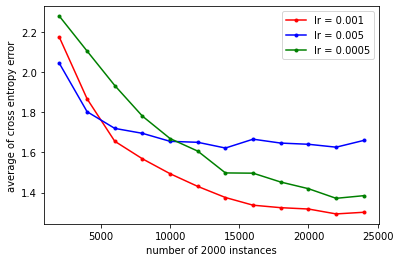

In [0]:
import matplotlib.pyplot as plt

# plot graph
print('Finished Training')
plot_index = range(2000, 25000, 2000)

plt.plot(plot_index, relu_running_losses, "r.-", label="lr = 0.001")
plt.plot(plot_index, lr0005relu_running_losses, "b.-", label="lr = 0.005")
plt.plot(plot_index, lr00005relu_running_losses, "g.-", label="lr = 0.0005")
plt.xlabel("number of instances")
plt.ylabel("average of cross entropy error")
plt.legend()
plt.show()

## Test Model

In [0]:
def run_model(dataloader):
  correct = 0
  total = 0
  # no_grad() set the require_grad flag to false temporarily, so the gradient will not be updated???
  with torch.no_grad():
    # iterate through batchs
      for data in dataloader:
          # data is a tuple (images, labels)
          images, labels = data
          # calculate the output from the image inputs in the batch
          # return value is tensor
          outputs = net(images)
          # get the prediected labels from the outputs.data
          # use max(input=outputs.data, dim=1), it outputs a named tuple (value, indices)
          # the result is the max value in each row and its index
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct, total

correct_train, total_train = run_model(trainloader)
print('Accuracy of the network on the 50000 train images: %d %%' % (
    100 * correct_train / total_train))

correct_test, total_test = run_model(testloader)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct_test / total_test))

Accuracy of the network on the 50000 train images: 68 %
Accuracy of the network on the 10000 test images: 63 %
